In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

path = "/content/gdrive/My Drive/Text-Mining"

Mounted at /content/gdrive


Workflow:
- analisi descrittive dati
  - pulizia dataset
  - rimozione duplicati
  - creazione variabile target
  - creazione Dataset finale

- preprocessing
  - rimozione stop-words
  - rimozione punteggiatura
  - rimozione numeri
  - lower-case
  - tokenization
  - lemmatization
  - POS
- text representation
  - count 
  - tf-idf
  - word-embeddings ad hoc
  - word-embeddings già addestrato
- modelli
  - Regressione logistica
  - SVM
  - Random Forest
  - Multi-layer Perception 
- validazione e confronto tra modelli
  - metriche valutazione modelli
  - selezione miglior modello

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, tqdm_notebook
tqdm.pandas(tqdm_notebook)
import pickle

from PIL import Image
from wordcloud import WordCloud, STOPWORDS

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
from nltk import pos_tag
import string
import re

!pip install langdetect
from langdetect import detect

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
     |████████████████████████████████| 983kB 4.9MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993194 sha256=61388af4d62e4892089e834a915bd16b8ec60877294aa32a833facbff808dbf6
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect


In [ ]:
def get_wordnet_pos(word):    
    """Mapping del POS tag con il token in input

    Parameters
    ----------
    word : str
        La parola da cui recuperare il POS tag

    Returns
    -------
    str
        POS tag associato al token in input
    """
    
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


def preprocessing(text):
    """ Preprocessing del testo

    Parameters
    ----------
    text : str
        La parola su cui eseguire il preprocessing

    Returns
    -------
    str
        testo pulito

    """
    try:
      # rimozione spazi bianchi iniziali e finali
      text = text.strip()
      regex = re.compile('[^a-zA-Z ][^0-9]')
      text = regex.sub('', text)
      text = re.sub(r"\d+", "", text)
      
      # rimozione puntegiatura e altri caratteri
      text = text.translate(str.maketrans('', '', string.punctuation+'‘“”—'))
      text = text.replace("‘", "")
      text = text.replace("’", "")
      text = text.replace("“", "")
      text = text.replace("”", "")
      text = text.replace("—", "")

      # trasformazione in minuscolo del testo
      text = text.lower()

      # word tokenize
      text = nltk.tokenize.word_tokenize(text)

      # rimozione stopwords
      stop_words = nltk.corpus.stopwords.words('english')
      text = [w for w in text if w not in stop_words]
      
      # lemmitize token con pos tag di nltk
      lemmatizer = nltk.stem.WordNetLemmatizer()
      text = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in text])
      
      return text

    except:
        return None

# Preporocessing del dataset

In [ ]:
# Caricamento dei dataset della prima fonte
dft = pd.read_csv(path+"/True.csv")
dff = pd.read_csv(path+"/Fake.csv")

Ci sono 21417 righe nel dataset, nella variabile titolo ci sono 20826 valori unici, quindi alcuni titoli si ripeteranno più volte, mentre nella variabile testo ci sono 21192 valori unici rispetto ai 21417 testi totali. La tipologia degli articoli descritta dalla variabile 'subject' evidenzia che sono solamente di due tipi. 

In [ ]:
# Assegnazione delle etichette alle rispettive notizie e creazione di un unico dataset
data_true=dft.drop_duplicates(subset=['text'])
data_fake=dff.drop_duplicates(subset=['text'])

data_true.loc[:,'target']='True'
data_fake.loc[:,'target']='Fake'
df1 = data_true.append(data_fake).reset_index()

In [ ]:
# Rimozione spazi iniziali e finali
df1['text'] = df1['text'].str.strip()

# Rimozione testi vuoti o duplicati
df1 = df1[df1['text']!='']
df1 = df1.drop_duplicates(subset='text')

# Calcolo lunghezza testi e filtraggio
df1['n_word'] = df1['text'].progress_map(lambda x: len(x.split()))
df1 = df1[df1['n_word'] > 1]

# Identificazione della lingua e selezione dei soli testi inglesi
df1['lang'] = df1['text'].progress_map(lambda x: detect(x))
df1 = df1[df1['lang'] == 'en']

# Preprocessing delle notizie
df1['pretext'] = df1['text'].progress_map(preprocessing)
df1 = df1.drop_duplicates(subset='pretext')

In [ ]:
print(df1.describe(include='all'))
print(df1.head())

In [ ]:
# Scrittura su file del dataset
df1.to_pickle(path + '/Dataset/df1.pkl')

In [ ]:
# Caricamento del secondo dataset
df2 = pd.read_csv(path+"/train_news.csv")

In [ ]:
# Rimozione spazi iniziali e finali
df2['news'] = df2['news'].str.strip()

# Rimozione testi vuoti o duplicati
df2 = df2[df2['news'] != ""]
df2 = df2.drop_duplicates(subset='news')
df2 = df2[['news', 'label']].dropna()

# Calcolo lunghezza testi e filtraggio
df2['n_word'] = df2['news'].progress_map(lambda x: len(x.split()))
df2 = df2[df2['n_word'] > 1]

# Identificazione della lingua e selezione dei soli testi inglesi
df2['lang'] = df2['news'].progress_map(lambda x: detect(x))
df2 = df2[df2['lang'] == 'en']

# Preprocessing
df2['pretext']=df2['news'].progress_map(preprocessing)
df2 = df2.drop_duplicates(subset='pretext')

# Definizione etichette nello stesso model del primo dataset
df2['label'] = df2['label'].apply(lambda x: 'True' if x == 0 else 'Fake')

In [ ]:
print(df2.describe(include='all'))
print(df2.head())

In [ ]:
# Scrittura su file del dataset
df2.to_pickle(path + '/Dataset/df2.pkl')

In [ ]:
# Caricamento dei due dataset da file
df1 = pd.read_pickle(path + '/Dataset/df1.pkl')
df2 = pd.read_pickle(path + '/Dataset/df2.pkl')

In [ ]:
# Sample dei dataframe
df1_sample = df1.sample(n=5000, random_state=1)
df2_sample = df2.sample(n=5000, random_state=1)

In [ ]:
# Merge dei dataframe
df_finale = df2_sample[['news', 'label', 'pretext']].append(df1_sample[['text', 'target', 'pretext']]
                              .rename(columns={"text": "news", "target": "label"}))
df_finale.shape

(10000, 3)

In [ ]:
print(df_finale.describe(include='all'))
print(df_finale.head())

,news,label,pretext
count,10000,10000,10000
unique,10000,2,10000
top,"BAYONNE, N. J. — Nicole Adamczyk’s drinking...",True,brasilia reuters brazil planning minister mond...
freq,1,5406,1


       news  pretext
label               
Fake   4639     4639
True   5361     5361


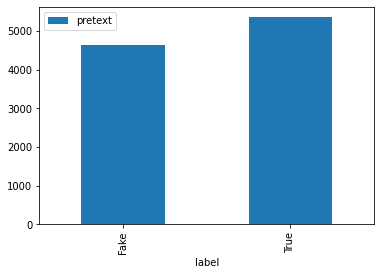

In [ ]:
df_distr_label = df_finale.groupby(['label']).count()
print(df_distr_label)
df_distr_label.reset_index().plot.bar(x='label', y='pretext')

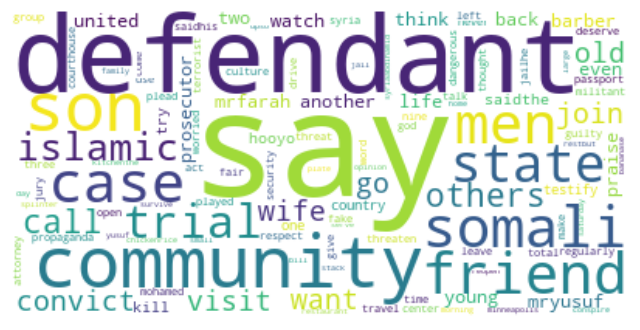

In [ ]:
# Word Cloud di una notizia vera
mask_true = np.array(Image.open(path + "/real.PNG"))
stopwords = set(STOPWORDS)
wc_true = WordCloud(background_color="white", max_words=2000,
        stopwords=stopwords, contour_width=3, contour_color='steelblue')
wc_true.generate(df_finale.iloc[0].pretext)
plt.figure(figsize=(8,6), dpi=100)
plt.imshow(wc_true, interpolation='bilinear')
plt.axis("off")
plt.show()

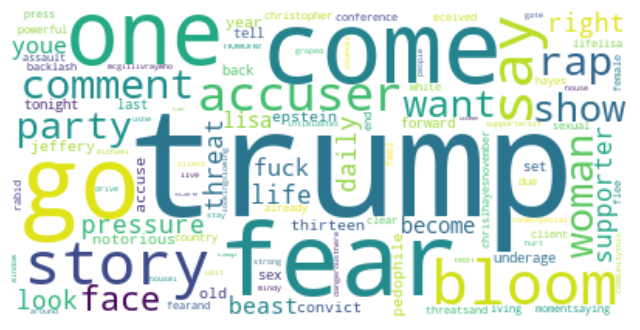

In [ ]:
# Word Cloud di una notizia falsa
mask_fake = np.array(Image.open(path + "/fake.PNG"))
stopwords = set(STOPWORDS)
wc_fake = WordCloud(background_color="white", max_words=2000, 
        stopwords=stopwords, contour_width=10, contour_color='steelblue')
wc_fake.generate(df_finale.iloc[1233].pretext)
plt.figure(figsize=(8,6), dpi=100)
plt.imshow(wc_fake, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# Scrittura su file del dataset
df_finale.to_pickle(path + '/Dataset/df_finale.pkl')

In [ ]:
# Caricamento del dataset
df_finale = pd.read_pickle(path + '/Dataset/df_finale.pkl')

# Text Rappresentation

In questa sezione si definiscono le rappresentazioni dei testi utilizzati poi dai modelli. Si utilizza il conteggio della frequenza delle parole e il Tf-Idf considerando più dimensioni degli n-grammi: i solo unigrammi, i solo bigrammi, i soli trigrammi, unigrammi e bigrammi, bigrammi e trigrammi e infine tutti e tre insieme.\
Si considerano inoltre anche i word embeddings, in particolare il modello Doc2Vec, creati sia tramite un modello già addestrato su testi di notizie e sia utilizzando un modello addestrato direttamente sui testi del train set.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Creazione del train set (67%) e del test set (33%)
X_train, X_test, y_train, y_test = train_test_split(df_finale['pretext'], 
                                                    df_finale['label'], test_size=0.33, random_state=1)

## Rappresentazione tramite la frequenza
Creazione deile rappresentazone della fequenza e del Tf-idf con i diversi tipi di n-grammi.

In [ ]:
# Grid search per le dimensioni degli n-grammi con il count
count_vectorize_grid_search = list()
for i in tqdm(range(1,4)):
  for j in range(i, 4):
    count_vect = CountVectorizer(ngram_range=(i, j), lowercase=False)
    X_train_counts = count_vect.fit_transform(X_train)
    X_test_counts  = count_vect.transform(X_test)
    count_vectorize_grid_search.append((count_vect, X_train_counts, X_test_counts))

In [ ]:
# Grid search per le dimensioni degli n-grammi con il tfidf
tfidf_vectorize_grid_search = list()
for i in tqdm(range(1,4)):
  for j in range(i, 4):
    tfidf_vect = TfidfVectorizer(ngram_range=(i, j), lowercase=False)
    X_train_tfidf = tfidf_vect.fit_transform(X_train)
    X_test_tfidf  = tfidf_vect.transform(X_test)
    tfidf_vectorize_grid_search.append((tfidf_vect, X_train_tfidf, X_test_tfidf))

In [ ]:
# Si salvano su file i Vectorizer da usare per i vari modelli
for vec in tqdm(count_vectorize_grid_search):
    filename = 'vec_count_'+str(vec[0].get_params()['ngram_range'])+'.sav'
    pickle.dump(vec[0], open(path + '/modelli/'+filename, 'wb'))

for vec in tqdm(tfidf_vectorize_grid_search):
    filename = 'vec_tfidf_'+str(vec[0].get_params()['ngram_range'])+'.sav'
    pickle.dump(vec[0], open(path + '/modelli/'+filename, 'wb'))

## Modelli Doc2Vec
Creazione della rappresentazione con i Word Embeddings sia con un modello addestrato ad hoc sul test set sia con un modello già addestrato. 

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

In [ ]:
def labeled_vectors(model, tagged_docs):
    """Inferenza dei vettori dal modello Doc2Vec
     
    Parameters
    ----------
    model : Doc2Vec
        Modello Doc2Vec
    
    tagged_docs : Iterator
        Lista di documenti a cui associare i vettori

    Returns
    -------
    targets
        La variabile target

    regressors
        I vettori dei regressori
    """

    sents = tagged_docs
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps = 10)) for doc in tqdm(sents)])
    return targets, regressors

In [ ]:
# Tagged del test e del train set
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in tqdm(enumerate(X_train))]
tagged_data_test = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in tqdm(enumerate(X_test))]

### Modello Doc2Vec ad hoc

In [ ]:
# Definizione del modello di Doc2Vec e suo addestramento
max_epochs = 50
vec_size = 300
alpha = 0.025

model = Doc2Vec(vector_size=vec_size, 
                dm=0,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1)

model.build_vocab(tagged_data)

for epoch in tqdm(range(max_epochs)):
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.epochs)
    # diminuzione del learning rate
    model.alpha -= 0.0002
    model.min_alpha = model.alpha

In [ ]:
# Salvataggio del modello su file
model.save(path + "/modelli/d2v_300v_50eph.model")

In [ ]:
# Caricamento del modello da file
model= Doc2Vec.load(path + "/modelli/d2v_300v_50eph.model")

In [ ]:
# Creazione dei vettori del test e del train tramite l'iferenza dal modello
y_train_doc2vec, X_train_doc2vec = labeled_vectors(model, tagged_data)
y_test_doc2vec, X_test_doc2vec = labeled_vectors(model, tagged_data_test)

### Modello Doc2Vec già addestrato.

In [ ]:
import gensim.models

In [ ]:
model_pre_train = gensim.models.Doc2Vec.load(path + '/apnews_dbow/doc2vec.bin')

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:566: UserWarning: The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.
  warnings.warn("The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.")
/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [ ]:
y_train_doc2vec_pre_train, X_train_doc2vec_pre_train = labeled_vectors(model_pre_train, tagged_data)
y_test_doc2vec_pre_train, X_test_doc2vec_pre_train = labeled_vectors(model_pre_train, tagged_data_test)

# Modelli
In questa sezione si presentano i risultati, in termini di Accuracy, dei modelii individuati, in particolare si testano:
- Regressione Logistica
- Support Vector Machine
- Random Forest
- Multi-layer Perceptron

Ognuno dei quattro modelli è testato sia con le rappresentazioni testuali dei word embeddings sia con la frequenza e il Tf-Idf per ogni combinazione degli n-grammi tramite una grid search.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score

## Modelli con la frequenza

In [ ]:
# Grid search per la Logistic Regression
res = list()
for elem in tqdm(count_vectorize_grid_search):
    LR_count = LogisticRegression(max_iter=200)
    LR_count.fit(elem[1], y_train)

    # Salvataggio su file
    filename = 'LR_count_'+str(elem[0].get_params()['ngram_range'])+'.sav'
    pickle.dump(LR_count, open(path + '/modelli/'+filename, 'wb'))
    
    predictions_LR_count = LR_count.predict(elem[2])
    accuracy = accuracy_score(predictions_LR_count, y_test)*100
    res.append([elem[0].get_params()['ngram_range'], accuracy])
    
df_LR = pd.DataFrame(res, columns=['Modello', 'Accuracy LR'])

In [ ]:
# Grid search per la Support vector machine
res = list()
for elem in tqdm(count_vectorize_grid_search):
    SVC_count = LinearSVC(max_iter=2000)
    SVC_count.fit(elem[1], y_train)
    
    # Salvataggio su file
    filename = 'SVM_count_'+str(elem[0].get_params()['ngram_range'])+'.sav'
    pickle.dump(SVC_count, open(path + '/modelli/'+filename, 'wb'))

    predictions_SVC_count = SVC_count.predict(elem[2])
    accuracy = accuracy_score(predictions_SVC_count, y_test)*100
    res.append([elem[0].get_params()['ngram_range'], accuracy])

df_SVM = pd.DataFrame(res, columns=['Modello', 'Accuracy SVM'])

In [ ]:
# Grid search per la Random Forest
res = list()
for elem in tqdm(count_vectorize_grid_search):
    RF_count = RandomForestClassifier(random_state=0)
    RF_count.fit(elem[1], y_train)

    # Salvataggio su file
    filename = 'RF_count_'+str(elem[0].get_params()['ngram_range'])+'.sav'
    pickle.dump(RF_count, open(path + '/modelli/'+filename, 'wb'))
    
    predictions_RF_count = RF_count.predict(elem[2])
    accuracy = accuracy_score(predictions_RF_count, y_test)*100
    res.append([elem[0].get_params()['ngram_range'], accuracy])

df_RF = pd.DataFrame(res, columns=['Modello', 'Accuracy RF']) 

In [ ]:
# Grid search per il Multi-layer Perceptron
res = list()
for elem in tqdm(count_vectorize_grid_search):
    MLP_count = MLPClassifier(hidden_layer_sizes=(10, 10), solver='adam', 
                              alpha=1e-5, random_state=1)
    MLP_count.fit(elem[1], y_train)

    # Salvataggio su file
    filename = 'MLP_count_'+str(elem[0].get_params()['ngram_range'])+'.sav'
    pickle.dump(MLP_count, open(path + '/modelli/'+filename, 'wb'))

    predictions_MLP_count = MLP_count.predict(elem[2])
    accuracy = accuracy_score(predictions_MLP_count, y_test)*100
    res.append([elem[0].get_params()['ngram_range'], accuracy])

df_MLP = pd.DataFrame(res, columns=['Modello', 'Accuracy MLP'])

In [ ]:
# Accuracy dei modelli
df_res_count = pd.read_csv(path+'/Dataset/df_res_count.csv')
df_res_count

,n-grammi,LR_accuracy,MLP_accuracy,RF_accuracy,SVM_accuracy
0,"(1, 1)",91.090909,89.454545,86.181818,90.060606
1,"(1, 2)",91.545455,79.000000,85.848485,90.636364
2,"(1, 3)",91.121212,80.242424,85.454545,90.333333
3,"(2, 2)",85.969697,89.878788,85.000000,82.757576
4,"(2, 3)",83.878788,83.909091,84.545455,80.757576
5,"(3, 3)",69.818182,68.787879,70.787879,62.878788


## Modelli con il Tf-Idf

In [ ]:
# Grid search per la Logistic Regression
res = list()
for elem in tqdm(tfidf_vectorize_grid_search):
    LR_tfidf = LogisticRegression(max_iter=200)
    LR_tfidf.fit(elem[1], y_train)

    # Salvataggio su file
    filename = 'LR_tfidf_'+str(elem[0].get_params()['ngram_range'])+'.sav'
    pickle.dump(LR_tfidf, open(path + '/modelli/'+filename, 'wb'))
    
    predictions_LR_tfidf = LR_tfidf.predict(elem[2])
    accuracy = accuracy_score(predictions_LR_tfidf, y_test)*100
    res.append([elem[0].get_params()['ngram_range'], accuracy])
    
df_LR = pd.DataFrame(res, columns=['Modello', 'Accuracy LR'])

In [ ]:
# Grid search per la Support Vector Machines
res = list()
for elem in tqdm(tfidf_vectorize_grid_search):
    SVC_tfidf = LinearSVC(max_iter=1000)
    SVC_tfidf.fit(elem[1], y_train)

    # Salvataggio su file
    filename = 'SVM_tfidf_'+str(elem[0].get_params()['ngram_range'])+'.sav'
    pickle.dump(SVC_tfidf, open(path + '/modelli/'+filename, 'wb'))
    
    predictions_SVC_tfidf = SVC_tfidf.predict(elem[2])
    accuracy = accuracy_score(predictions_SVC_tfidf, y_test)*100
    res.append([elem[0].get_params()['ngram_range'], accuracy])
    
df_LR = pd.DataFrame(res, columns=['Modello', 'Accuracy LR'])

In [ ]:
# Grid search per la Random Forest
res = list()
for elem in tqdm(tfidf_vectorize_grid_search):
    RF_tfidf = RandomForestClassifier(random_state=0)
    RF_tfidf.fit(elem[1], y_train)

    # Salvataggio su file
    filename = 'RF_tfidf_'+str(elem[0].get_params()['ngram_range'])+'.sav'
    pickle.dump(RF_tfidf, open(path + '/modelli/'+filename, 'wb'))
    
    predictions_RF_tfidf = RF_tfidf.predict(elem[2])
    accuracy = accuracy_score(predictions_RF_tfidf, y_test)*100
    res.append([elem[0].get_params()['ngram_range'], accuracy])
    
df_LR = pd.DataFrame(res, columns=['Modello', 'Accuracy LR'])

In [ ]:
# Grid search per la  Multi-layer Perceptron
res = list()
for elem in tqdm(tfidf_vectorize_grid_search):
    MLP_tfidf = MLPClassifier(hidden_layer_sizes=(10, 10), solver='adam', alpha=1e-5, random_state=1)
    MLP_tfidf.fit(elem[1], y_train)

    # Salvataggio su file
    filename = 'MLP_tfidf_'+str(elem[0].get_params()['ngram_range'])+'.sav'
    pickle.dump(MLP_tfidf, open(path + '/modelli/'+filename, 'wb'))
    
    predictions_MLP_tfidf = MLP_tfidf.predict(elem[2])
    accuracy = accuracy_score(predictions_MLP_tfidf, y_test)*100
    res.append([elem[0].get_params()['ngram_range'], accuracy])
    
df_LR = pd.DataFrame(res, columns=['Modello', 'Accuracy LR'])

In [ ]:
# Accuracy dei modelli
df_res_tfidf = pd.read_csv(path+'/Dataset/df_res_tfidf.csv')
df_res_tfidf

,n-grammi,LR_accuracy,MLP_accuracy,RF_accuracy,SVM_accuracy
0,"(1, 1)",90.121212,91.606061,86.393939,92.060606
1,"(1, 2)",88.242424,90.515152,86.212121,91.121212
2,"(1, 3)",86.818182,88.393939,86.393939,89.666667
3,"(2, 2)",85.303030,87.090909,85.363636,89.212121
4,"(2, 3)",81.727273,86.696970,84.787879,88.030303
5,"(3, 3)",70.939394,83.696970,72.060606,80.333333


## Confronto tra i modelli
L'addestramento dei modelli ha richiesto molto tempo e risorse computazionali, per rendere più facile il loro confronto si è salvata ogni rappresentazione testuale utilizzata con i relativi modelli addestrati. Nelle celle successive si caricano in memoria i vari modelli e se ne calcola l'accuracy.

In [ ]:
# Lettura da file dei vectorizer del Count e del tfidf
dict_vect = dict()
for filename in tqdm(os.listdir(path+'/modelli')):
    if 'vec_count' in filename:
        model = pickle.load(open(path+'/modelli/'+filename, 'rb'))
        dict_vect['count'+str(model.get_params()['ngram_range'])] = model
    elif 'vec_tfidf' in filename:
        model = pickle.load(open(path+'/modelli/'+filename, 'rb'))
        dict_vect['tfidf'+str(model.get_params()['ngram_range'])] = model

In [ ]:
# Calcolo dell'accuracy per ogni rappresentazione del testo e per ogni modello
res_count = list()
res_tfidf = list()
model_names = [n for n in os.listdir(path+'/modelli') if 'vec' not in n]
for filename in tqdm(model_names):
    if 'count' in filename:
        model = pickle.load(open(path+'/modelli/'+filename, 'rb'))
        vec = dict_vect.get('count'+filename[-10:-4])
        pred = model.predict(vec.transform(X_test))
        accuracy = accuracy_score(pred, y_test)*100
        res_count.append({'n-grammi':vec.get_params()['ngram_range'], 
                          'modello':f'{filename.split("_")[0]}_accuracy', 'accuracy':accuracy})
    elif 'tfidf' in filename:
        model = pickle.load(open(path+'/modelli/'+filename, 'rb'))
        vec = dict_vect.get('tfidf'+filename[-10:-4])
        pred = model.predict(vec.transform(X_test))
        accuracy = accuracy_score(pred, y_test)*100
        res_tfidf.append({'n-grammi':vec.get_params()['ngram_range'], 
                          'modello':f'{filename.split("_")[0]}_accuracy', 'accuracy':accuracy})

Si riportano i risultati dei modelli. Per la rappresentazione con la sola frequenza il modello migliore è la Regressione Logistica considerando sia gli unigrammi che i bigrammi. Nel caso della reppresentazione con il Tf-Idf il modello migliore è il SVM con i solo unigrammi.

In [ ]:
# Accuracy dei modelli per la frequenza
df_res_count = pd.DataFrame(res_count).pivot(index='n-grammi', columns='modello', values='accuracy')
df_res_count

modello,LR_accuracy,MLP_accuracy,RF_accuracy,SVM_accuracy
n-grammi,,,,
"(1, 1)",91.090909,89.454545,86.181818,90.060606
"(1, 2)",91.545455,79.000000,85.848485,90.636364
"(1, 3)",91.121212,80.242424,85.454545,90.333333
"(2, 2)",85.969697,89.878788,85.000000,82.757576
"(2, 3)",83.878788,83.909091,84.545455,80.757576
"(3, 3)",69.818182,68.787879,70.787879,62.878788


In [ ]:
# Accuracy dei modelli per il TF-Idf
df_res_tfidf = pd.DataFrame(res_tfidf).pivot(index='n-grammi', columns='modello', values='accuracy')
df_res_tfidf

modello,LR_accuracy,MLP_accuracy,RF_accuracy,SVM_accuracy
n-grammi,,,,
"(1, 1)",90.121212,91.606061,86.393939,92.060606
"(1, 2)",88.242424,90.515152,86.212121,91.121212
"(1, 3)",86.818182,88.393939,86.393939,89.666667
"(2, 2)",85.303030,87.090909,85.363636,89.212121
"(2, 3)",81.727273,86.696970,84.787879,88.030303
"(3, 3)",70.939394,83.696970,72.060606,80.333333


In [ ]:
# Scrittura su file dei risultati
df_res_count.to_csv(path+'/Dataset/df_res_count.csv')
df_res_tfidf.to_csv(path+'/Dataset/df_res_tfidf.csv')

In [ ]:
# In alternativa si leggono i dataframe con i risultati già salvati
df_res_count = pd.read_csv(path+'/Dataset/df_res_count.csv')
df_res_tfidf = pd.read_csv(path+'/Dataset/df_res_tfidf.csv')

Si mostra anche un grafico con l'andamento dell'accuracy al variare delle dimensioni degli n-grammi considerati, dai soli unigrammi a unigrammi, bigrammi e trigrammi. Si nota che nelcaso dei soli trigrammi tutti i modelli in entrambe le rappresentazioni raggiungono un'accuracy bassa.

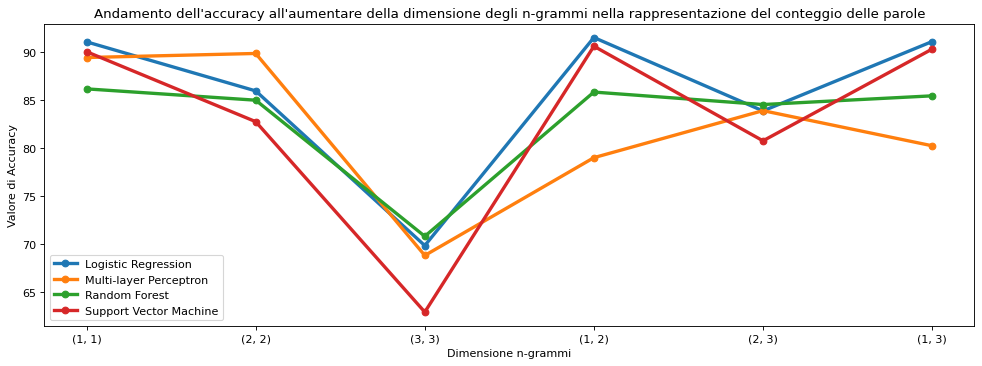

In [ ]:
ord_index = [0, 3, 5, 1, 4, 2]
df_plot1 = df_res_count.reindex(ord_index)

plt.figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
plt.plot('n-grammi', 'LR_accuracy', data=df_plot1, marker='o', markersize=6, linewidth=3, label='Logistic Regression')
plt.plot('n-grammi', 'MLP_accuracy', data=df_plot1, marker='o', markersize=6, linewidth=3, label='Multi-layer Perceptron')
plt.plot('n-grammi', 'RF_accuracy', data=df_plot1, marker='o', markersize=6, linewidth=3, label='Random Forest')
plt.plot('n-grammi', 'SVM_accuracy', data=df_plot1, marker='o', markersize=6, linewidth=3, label='Support Vector Machine')
plt.title('Andamento dell\'accuracy all\'aumentare della dimensione degli n-grammi nella rappresentazione del conteggio delle parole')
plt.xlabel('Dimensione n-grammi')
plt.ylabel('Valore di Accuracy')
plt.legend()
plt.show()

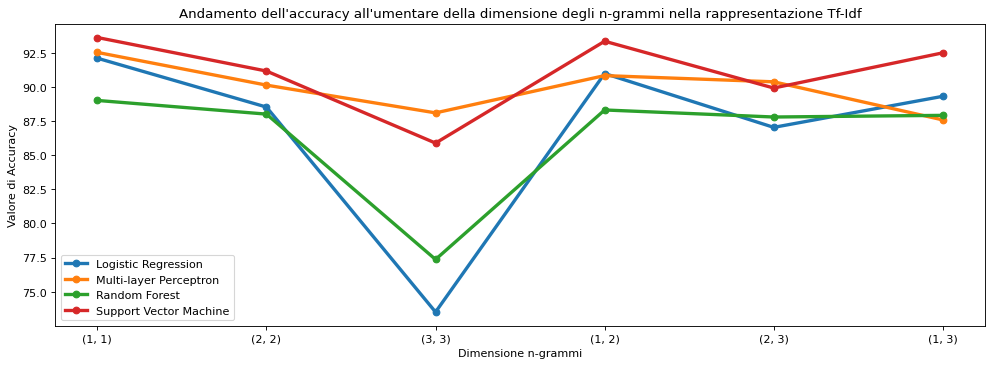

In [ ]:
df_plot2 = df_res_tfidf.reindex(ord_index)

plt.figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
plt.plot('n-grammi', 'LR_accuracy', data=df_plot2, marker='o', markersize=6, linewidth=3, label='Logistic Regression')
plt.plot('n-grammi', 'MLP_accuracy', data=df_plot2, marker='o', markersize=6, linewidth=3, label='Multi-layer Perceptron')
plt.plot('n-grammi', 'RF_accuracy', data=df_plot2, marker='o', markersize=6, linewidth=3, label='Random Forest')
plt.plot('n-grammi', 'SVM_accuracy', data=df_plot2, marker='o', markersize=6, linewidth=3, label='Support Vector Machine')
plt.title('Andamento dell\'accuracy all\'aumentare della dimensione degli n-grammi nella rappresentazione Tf-Idf')
plt.xlabel('Dimensione n-grammi')
plt.ylabel('Valore di Accuracy')
plt.legend()
plt.show()

## Filtraggio dei token
Concentrandosi sui due modelli migliori si è cercato di capire se filtrando gli n-grammi in base alla loro frequenza si potesse aumentare l'accuracy. Si è usata la differenza interquartile per identificare un limite massimo e minimo delle frequenze delle parole da considerare.

Filtraggio delle parole nel caso della frequenza utilizzando unigrammi e bigrammi

In [ ]:
# Rappresentazione migliore per la frequenza
count_vect = CountVectorizer(ngram_range=(1, 2), lowercase=False)
X_train_counts = count_vect.fit_transform(X_train)

In [ ]:
# Definizione di un dataframe in cui ad ogni parola è associato il numero di occorrenze nel corpus
l = list()
for i in tqdm(range(14)):
    if i == 0:
        m = X_train_counts[:500,].toarray().sum(axis=0)
        df_count = pd.DataFrame(m, index=count_vect.get_feature_names())
        l.append(df_count)
    elif 0 < i < 13:
        m = X_train_counts[i*500:(i+1)*500,].toarray().sum(axis=0)
        df_count = pd.DataFrame(m, index=count_vect.get_feature_names())
        l.append(df_count)
        #name = count_vect.get_feature_names()
    else:
        m = X_train_counts[i*500:,].toarray().sum(axis=0)
        df_count = pd.DataFrame(m, index=count_vect.get_feature_names())
        l.append(df_count)


In [ ]:
df_count_freq = pd.concat(l, axis=1).sum(axis=1).to_frame()
df_count_freq = df_count_freq.rename(columns={0:'count'}).sort_values(by=['count'])
df_count_freq.head()

,count
long regard,1
percent northern,1
percent noncitizen,1
percent noand,1
percent ninety,1


In [ ]:
# Scrittura su file
df_count_freq.to_pickle(path + '/Dataset/df_count_freq.pkl')

In [ ]:
# Calcolo numero di occorrenze delle parole nel corpus
df_num_occ = df_count_freq.reset_index().groupby(['count']).count().reset_index()
df_num_occ.head()

,count,index
0,1,1498804
1,2,136913
2,3,43751
3,4,20585
4,5,11987


In [ ]:
# Calcolo dei quartili
Q1 = df_count_freq['count'].quantile(0.25)
Q3 = df_count_freq['count'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
print('Differenza Inter-Quartile: ', IQR)
print(f'Limite inferiore: {lower} - Limite superiore: {upper}' )

Differenza Inter-Quartile:  0.0
Limite inferiore: 1.0 - Limite superiore: 1.0


In [ ]:
# Filtraggio delle parole
words_filter_count = df_count_freq[(df_count_freq['count']>=lower) & (df_count_freq['count']<=upper)]
new_voc_count = words_filter_count.index
len(new_voc_count)

1498804

In [ ]:
df_count_freq.boxplot(['count'], figsize=(10, 10))

In [ ]:
# Nuova rappresentazione che considera solo le parole selezionate
count_vect_filter = CountVectorizer(ngram_range=(1, 2), lowercase=False, vocabulary=new_voc_count)
X_train_counts_filter = count_vect_filter.fit_transform(X_train)
X_test_counts_filter = count_vect_filter.transform(X_test)

In [ ]:
# Addestramento del nuovo modello
LR_count_filter = LogisticRegression(max_iter=1000)
LR_count_filter.fit(X_train_counts_filter, y_train)
predictions_LR_count_filter = LR_count_filter.predict(X_test_counts_filter)
print("LR con filtraggio della frequenza: Accuracy -> ", accuracy_score(predictions_LR_count_filter, y_test)*100)

Logistic Regression Accuracy Score ->  68.15151515151516


Si osserva una significativa diminuzione del valore di accuracy

Filtraggio delle parole nel caso del Tf-Idf utilizzando unigrammi e bigrammi

In [ ]:
# Rappresentazione migliore per il Tf-Idf
tfidf_vect = TfidfVectorizer(ngram_range=(1, 1), lowercase=False)
X_train_tfidf = tfidf_vect.fit_transform(X_train)
X_test_tfidf = tfidf_vect.transform(X_test)

In [ ]:
l = list()
for i in tqdm(range(14)):
    if i == 0:
        m = X_train_tfidf[:500,].toarray().sum(axis=0)
        df_count = pd.DataFrame(m, index=tfidf_vect.get_feature_names())
        l.append(df_count)
    elif 0 < i < 13:
        m = X_train_tfidf[i*500:(i+1)*500,].toarray().sum(axis=0)
        df_count = pd.DataFrame(m, index=tfidf_vect.get_feature_names())
        l.append(df_count)
        #name = count_vect.get_feature_names()
    else:
        m = X_train_tfidf[i*500:,].toarray().sum(axis=0)
        df_count = pd.DataFrame(m, index=tfidf_vect.get_feature_names())
        l.append(df_count)


In [ ]:
df_tfidf_freq = pd.concat(l, axis=1).sum(axis=1).to_frame()
df_tfidf_freq = df_tfidf_freq.rename(columns={0:'count'}).sort_values(by=['count'])
df_tfidf_freq.head()

,count
sobekhotepthutmose,0.007925
jewishaboveleft,0.007925
extremismsupremacism,0.007925
sterrotype,0.007925
ecognizedas,0.007925


In [ ]:
df_tfidf_freq.to_pickle(path + '/Dataset/df_tfidf_freq.pkl')

In [ ]:
# Calcolo dei quartili
Q1 = df_tfidf_freq['count'].quantile(0.25)
Q3 = df_tfidf_freq['count'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
print('Differenza Inter-Quartile: ', IQR)
print(f'Limite inferiore: {lower} - Limite superiore: {upper}' )

Differenza Inter-Quartile:  0.06548417230476092
Limite inferiore: -0.0520916097544876 - Limite superiore: 0.20984507946455605


In [ ]:
words_filter_filter = df_tfidf_freq[(df_tfidf_freq['count']>=lower) & (df_tfidf_freq['count']<=upper)]
new_voc_tfidf = words_filter_filter.index
len(new_voc_tfidf)

260540

In [ ]:
# Rappresentazione con le parole filtrate
tfidf_vect_tfidf = TfidfVectorizer(ngram_range=(1, 1), lowercase=False, vocabulary=new_voc_tfidf)
X_train_tfidf_filter = tfidf_vect_tfidf.fit_transform(X_train)
X_test_tfidf_filter = tfidf_vect.transform(X_test)

In [ ]:
# Modello migliore con il filtraggio delle parole
SVC_tfidf_filter = LinearSVC(max_iter=1000)
SVC_tfidf_filter.fit(X_train_tfidf_filter, y_train)
predictions_SVC_tfidf_filter = SVC_tfidf_filter.predict(X_test_tfidf_filter)
print("SVM con filtraggio della frequenza: Accuracy -> ", accuracy_score(predictions_SVC_tfidf_filter, y_test)*100)

Support Vector Machine Accuracy Score ->  70.84848484848484


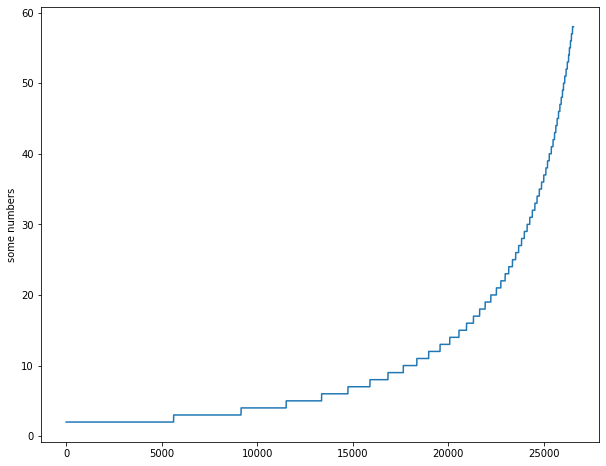

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,8))
plt.plot(np.sort(words_filter['count'].values))
plt.ylabel('some numbers')
plt.show()

## Modello Doc2Vec ad hoc

In [ ]:
# Lista finale dei risultati
res_Doc2Vec = list()

In [ ]:
LR_Doc2Vec = LogisticRegression(max_iter=200)
LR_Doc2Vec.fit(X_train_doc2vec, y_train)

predictions_LR_Doc2Vec = LR_Doc2Vec.predict(X_test_doc2vec)
accuracy = accuracy_score(predictions_LR_Doc2Vec, y_test)*100
res_Doc2Vec.append(accuracy)

In [ ]:
SVM_Doc2Vec = LinearSVC(max_iter=2000)
SVM_Doc2Vec.fit(X_train_doc2vec, y_train)

predictions_SVM_Doc2Vec = SVM_Doc2Vec.predict(X_test_doc2vec)
accuracy = accuracy_score(predictions_SVM_Doc2Vec, y_test)*100
res_Doc2Vec.append(accuracy)

In [ ]:
RF_Doc2Vec = RandomForestClassifier(random_state=0)
RF_Doc2Vec.fit(X_train_doc2vec, y_train)

predictions_RF_Doc2Vec = RF_Doc2Vec.predict(X_test_doc2vec)
accuracy = accuracy_score(predictions_RF_Doc2Vec, y_test)*100
res_Doc2Vec.append(accuracy)

In [ ]:
MLP_Doc2Vec = MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=1000, solver='adam', alpha=1e-5, random_state=1)
MLP_Doc2Vec.fit(X_train_doc2vec, y_train)

predictions_MLP_Doc2Vec = MLP_Doc2Vec.predict(X_test_doc2vec)
accuracy = accuracy_score(predictions_MLP_Doc2Vec, y_test)*100
res_Doc2Vec.append(accuracy)

## Modello Doc2Vec pre addestrato

In [ ]:
# Lista finale dei risultati
res_Doc2Vec_pre_train = list()

In [ ]:
LR_Doc2Vec_pre_train = LogisticRegression(max_iter=200)
LR_Doc2Vec_pre_train.fit(X_train_doc2vec_pre_train, y_train)

predictions_LR_Doc2Vec_pre_train = LR_Doc2Vec_pre_train.predict(X_test_doc2vec_pre_train)
accuracy = accuracy_score(predictions_LR_Doc2Vec_pre_train, y_test)*100
res_Doc2Vec_pre_train.append(accuracy)

In [ ]:
SVM_Doc2Vec_pre_train = LinearSVC(max_iter=1000)
SVM_Doc2Vec_pre_train.fit(X_train_doc2vec_pre_train, y_train)

predictions_SVM_Doc2Vec_pre_train = SVM_Doc2Vec_pre_train.predict(X_test_doc2vec_pre_train)
accuracy = accuracy_score(predictions_SVM_Doc2Vec_pre_train, y_test)*100
res_Doc2Vec_pre_train.append(accuracy)

In [ ]:
RF_Doc2Vec_pre_train = RandomForestClassifier(random_state=0)
RF_Doc2Vec_pre_train.fit(X_train_doc2vec_pre_train, y_train)

predictions_RF_Doc2Vec_pre_train = RF_Doc2Vec_pre_train.predict(X_test_doc2vec_pre_train)
accuracy = accuracy_score(predictions_RF_Doc2Vec_pre_train, y_test)*100
res_Doc2Vec_pre_train.append(accuracy)

In [ ]:
MLP_Doc2Vec_pre_train = MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=1000, solver='adam', alpha=1e-5, random_state=1)
MLP_Doc2Vec_pre_train.fit(X_train_doc2vec_pre_train, y_train)

predictions_MLP_Doc2Vec_pre_train = MLP_Doc2Vec_pre_train.predict(X_test_doc2vec_pre_train)
accuracy = accuracy_score(predictions_MLP_Doc2Vec_pre_train, y_test)*100
res_Doc2Vec_pre_train.append(accuracy)

In [ ]:
# Risultati finali dei modelli Doc2Vec
pd.DataFrame([res_Doc2Vec, res_Doc2Vec_pre_train], 
             columns=['LR', 'SVM', 'RF', 'MLP'], 
             index=['Doc2Vec ad hoc', 'Doc2Vec pre-train'])

,LR,SVM,RF,MLP
Doc2Vec ad hoc,85.878788,85.878788,82.787879,88.181818
Doc2Vec pre-train,83.606061,83.909091,80.333333,81.242424
